20.07.2019 al 31.07.2019

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import tools
from datetime import datetime
import matplotlib.pyplot as plt

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

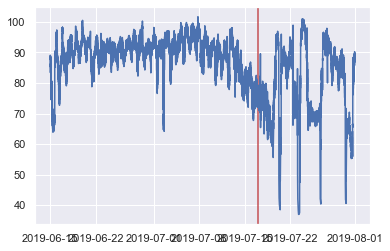

In [2]:
splits = ['15/06/2019','17/07/2019','01/08/2019']
d_1 = datetime.strptime(splits[0], "%d/%m/%Y")
d_2 = datetime.strptime(splits[2], "%d/%m/%Y")
df = pd.read_csv(r'..\data\untouched_data\caixa_canvis\2018\HTI889B.csv', sep=';')
df['Time'] = pd.to_datetime(df['Time'], format=tools.date_format)
df = df.set_index('Time').sort_index()[d_1:d_2]
plt.axvline(datetime(2019, 7, 17), color='r')
plt.plot(df)

In [3]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['HTI889B'], name='HTI889B'))
fig.update_layout(showlegend = True, title='Graph')
fig.show()

In [4]:
train, test = df[:'17/07/2019'], df['17/07/2019':]
train.shape, test.shape

((14603, 1), (7432, 1))

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(train[['HTI889B']])

train['HTI889B'] = scaler.transform(train[['HTI889B']])

ipykernel_launcher:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
TIME_STEPS = 300 #modificar

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)
X_train, y_train = create_sequences(train[['HTI889B']], train['HTI889B'])
X_test, y_test = create_sequences(test[['HTI889B']], test['HTI889B'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')


Training shape: (14303, 300, 1)
Testing shape: (7132, 300, 1)


In [7]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 300, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 300, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [8]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
403/403 [==============================] - 199s 495ms/step - loss: 0.1929 - val_loss: 0.2109
Epoch 2/100
403/403 [==============================] - 183s 453ms/step - loss: 0.1717 - val_loss: 0.2171
Epoch 3/100
403/403 [==============================] - 181s 450ms/step - loss: 0.1665 - val_loss: 0.2049
Epoch 4/100
403/403 [==============================] - 243s 604ms/step - loss: 0.1608 - val_loss: 0.1990
Epoch 5/100
403/403 [==============================] - 395s 979ms/step - loss: 0.1615 - val_loss: 0.2056
Epoch 6/100
403/403 [==============================] - 215s 533ms/step - loss: 0.1577 - val_loss: 0.2024
Epoch 7/100
403/403 [==============================] - 169s 421ms/step - loss: 0.1524 - val_loss: 0.1981
Epoch 8/100
403/403 [==============================] - 168s 418ms/step - loss: 0.1552 - val_loss: 0.1992
Epoch 9/100
403/403 [==============================] - 169s 419ms/step - loss: 0.1578 - val_loss: 0.2138
Epoch 10/100
403/403 [==============================] -

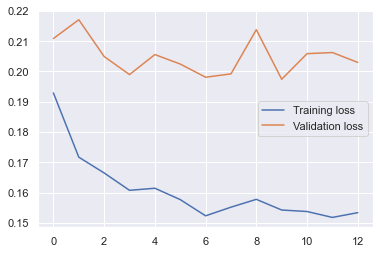

In [9]:
plt.plot(history.history['loss'], label ='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Reconstruction error threshold: 3.4958015417549353


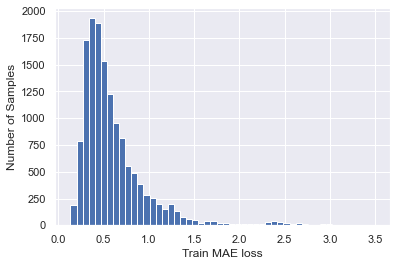

In [10]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

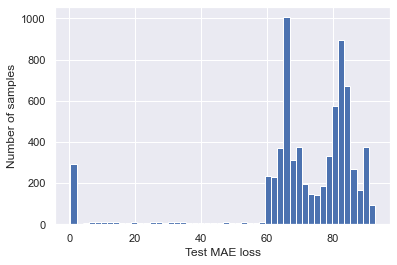

In [11]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [12]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['HTI889B'] = test[TIME_STEPS:]['HTI889B']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'))